## 4.뉴스 카테고리 다중분류
 ### 프로젝트: Vocabulary Size를 변경해서 시도해보기


In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## 1. 모든 단어 사용

In [2]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

2121728/2110848 [==============================] - 0s 0us/step


In [3]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [4]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


데이터 분포 확인해보기

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


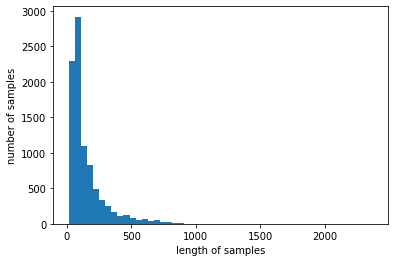

In [5]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

클래스의 분포를 확인

 모델의 성능에 영향을 줄 수 있는 요소이기 때문에 실제로 모든 클래스가 다 존재는 하는 것인지, 또 어떤 클래스가 유독 많은지와 같은 것들을 사전에 확인해 보아야 합니다.

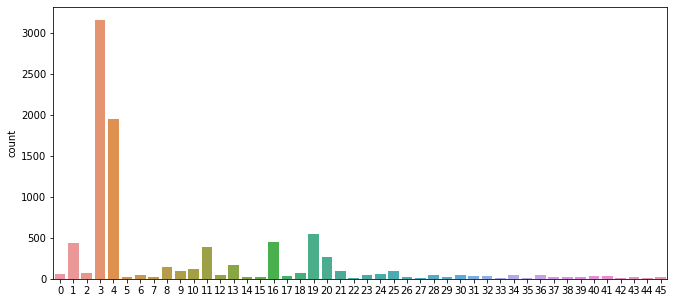

In [6]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

원본 뉴스 데이터로 복원해보기

In [7]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

565248/550378 [==============================] - 0s 0us/step


In [8]:
#index +3을 해주는 이유는 reuters.get_word_index에선 실제 단어에 맵핑한 정수에 -3을 설정해놓았기때문
index_to_word = { index+3 : word for word, index in word_index.items() }

In [9]:
print(index_to_word[4])
print(index_to_word[16])

the
it


In [10]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token
print('=3')

=3


첫 번째 훈련용 뉴스 기사를 원래 텍스트로 복원

In [11]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


전체 훈련용 뉴스 데이터와 전체 테스트용 뉴스 데이터를 텍스트 데이터로 변환해 보겠습니다.

In [12]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [13]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


In [14]:
x_train[:5]

['<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3',
 "<sos> generale de banque sa lt genb br and lt heller overseas corp of chicago have each taken 50 pct stakes in factoring company sa belgo factors generale de banque said in a statement it gave no financial details of the transaction sa belgo factors' turnover in 1986 was 17 5 billion belgian francs reuter 3",
 '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect th

In [15]:
x_test[:5]

['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt tengelmann warenhandelsgesellschaft of west germany reuter 3',
 "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration sra chairman arsenio yulo said yu

벡터화 하기

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

DTM을 생성하고, DTM의 크기를 확인해보겠습니다.

In [17]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 26506)


TF-IDF Matrix

In [18]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 26506)


나이브 베이즈 분류기

In [19]:
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

In [20]:
model = MultinomialNB()
model.fit(tfidfv, y_train)

MultinomialNB()

In [21]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = model.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("나이브 베이즈 정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

나이브 베이즈 정확도: 0.5997328584149599


F1-Score, Confusion Matrix

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [23]:
# confusion matrix 시각화
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
    df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(15,15))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('label')
    plt.xlabel('predicted value')

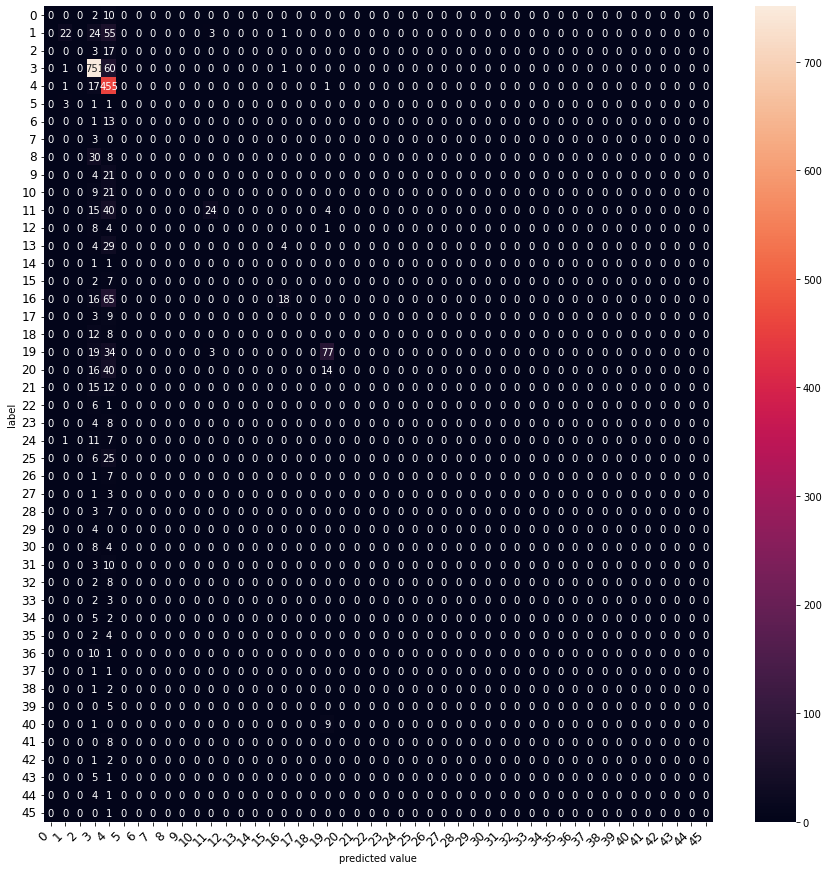

In [24]:
graph_confusion_matrix(model, tfidfv_test, y_test)

Complement Naive Bayes Classifier(CNB)

---



In [25]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [26]:
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7649154051647373


로지스틱 회귀(Logistic Regression)

---


In [27]:
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=10000)

In [28]:
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.813446126447017


선형 서포트 벡터 머신(Linear Support Vector Machine)

In [29]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC(C=1000, dual=False, max_iter=500, penalty='l1')

In [30]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7769367764915405


결정 트리(Decision Tree)

In [31]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [32]:
predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6211041852181657


랜덤 포레스트(Random Forest)


In [33]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [34]:
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6544968833481746


그래디언트 부스팅 트리(GradientBoostingClassifier)


In [35]:
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [36]:
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7702582368655387


보팅(Voting)


In [37]:
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=10000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft')

In [38]:
predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8187889581478184


각 모델에 대한 전체 훈련 함수 생성

In [39]:
def train_model(tfidfv, y_train, tfidfv_test, y_test):

  #나이브 베이즈 분류기
  nb = MultinomialNB()
  nb.fit(tfidfv, y_train)

  nb_predicted = nb.predict(tfidfv_test) # 테스트 데이터에 대한 예측
  print("나이브 베이즈 정확도:", accuracy_score(y_test, nb_predicted)) #예측값과 실제값 비교

  #CNB
  cb = ComplementNB()
  cb.fit(tfidfv, y_train)

  cb_predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
  print("CNB 정확도", accuracy_score(y_test, cb_predicted)) #예측값과 실제값 비교

  # 로지스틱 회귀
  lr = LogisticRegression(C=10000, penalty='l2')
  lr.fit(tfidfv, y_train)

  lr_predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
  print("로지스틱 회귀 정확도:", accuracy_score(y_test, lr_predicted)) #예측값과 실제값 비교

  # 선형 서포트 벡터 머신
  lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
  lsvc.fit(tfidfv, y_train)

  lsvc_predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
  print("선형 서포트 벡터 머신 정확도:", accuracy_score(y_test, lsvc_predicted)) #예측값과 실제값 비교

  # 결정 트리
  tree = DecisionTreeClassifier(max_depth=10, random_state=0)
  tree.fit(tfidfv, y_train)

  tree_predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
  print("결정 트리 정확도:", accuracy_score(y_test, tree_predicted)) #예측값과 실제값 비교

  # 랜덤 포레스트
  forest = RandomForestClassifier(n_estimators=5, random_state=0)
  forest.fit(tfidfv, y_train)

  forest_predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
  print("랜덤 포레스트 정확도:", accuracy_score(y_test, forest_predicted)) #예측값과 실제값 비교

  # 그래디언트 부스팅 트리
  grbt = GradientBoostingClassifier(random_state=0) # verbose=3
  grbt.fit(tfidfv, y_train)

  grbt_predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
  print("그래디언트 부스팅 트리 정확도:", accuracy_score(y_test, grbt_predicted)) #예측값과 실제값 비교

  # 보팅
  voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
        ], voting='soft', n_jobs=-1)
  voting_classifier.fit(tfidfv, y_train)

  voting_classifier_predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
  print("보팅 정확도:", accuracy_score(y_test, voting_classifier_predicted)) #예측값과 실제값 비교

  return nb, cb, lr, lsvc, tree, forest, grbt, voting_classifier

## 빈도수 상위 5,000개의 단어만 사용

In [40]:
(x_train_5k, y_train_5k), (x_test_5k, y_test_5k) = reuters.load_data(num_words=5000, test_split=0.2)

In [41]:
# 텍스트 데이터로 변환
decoded = []
for i in range(len(x_train_5k)):
    t = ' '.join([index_to_word[index] for index in x_train_5k[i]])
    decoded.append(t)

x_train_5k = decoded
print(len(x_train_5k))

8982


In [42]:
# 텍스트 데이터로 변환
decoded = []
for i in range(len(x_test_5k)):
    t = ' '.join([index_to_word[index] for index in x_test_5k[i]])
    decoded.append(t)

x_test_5k = decoded
print(len(x_test_5k))

2246


In [43]:
#dtm 생성, 크기 확인
dtmvector = CountVectorizer()
x_train_dtm_5k = dtmvector.fit_transform(x_train_5k)
print(x_train_dtm_5k.shape)

#TF-IDF Matrix 생성, 크기 확인
tfidf_transformer = TfidfTransformer()
tfidfv_5k = tfidf_transformer.fit_transform(x_train_dtm_5k)
print(tfidfv_5k.shape)

x_test_dtm_5k = dtmvector.transform(x_test_5k) #테스트 데이터를 DTM으로 변환
tfidfv_test_5k = tfidf_transformer.transform(x_test_dtm_5k) #DTM을 TF-IDF 행렬로 변환

(8982, 4867)
(8982, 4867)


In [44]:
nb_5k, cb_5k, lr_5k, lsvc_5k, tree_5k, forest_5k, grbt_5k, voting_classifier_5k = train_model(tfidfv_5k, y_train_5k, tfidfv_test_5k, y_test_5k)

나이브 베이즈 정확도: 0.6731967943009796
CNB 정확도 0.7707034728406055


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


로지스틱 회귀 정확도: 0.8058771148708815


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


선형 서포트 벡터 머신 정확도: 0.7729296527159395
결정 트리 정확도: 0.6179875333926982
랜덤 포레스트 정확도: 0.701246660730187
그래디언트 부스팅 트리 정확도: 0.767586821015138
보팅 정확도: 0.8161175422974176


## 빈도수 상위 2,500개의 단어만 사용

In [45]:
(x_train_2k, y_train_2k), (x_test_2k, y_test_2k) = reuters.load_data(num_words=2500, test_split=0.2)

In [46]:
# 텍스트 데이터로 변환
decoded = []
for i in range(len(x_train_2k)):
    t = ' '.join([index_to_word[index] for index in x_train_2k[i]])
    decoded.append(t)

x_train_2k = decoded
print(len(x_train_2k))

8982


In [47]:
# 텍스트 데이터로 변환
decoded = []
for i in range(len(x_test_2k)):
    t = ' '.join([index_to_word[index] for index in x_test_2k[i]])
    decoded.append(t)

x_test_2k = decoded
print(len(x_test_2k))

2246


In [48]:
#dtm 생성, 크기 확인
dtmvector = CountVectorizer()
x_train_dtm_2k = dtmvector.fit_transform(x_train_2k)
print(x_train_dtm_2k.shape)

#TF-IDF Matrix 생성, 크기 확인
tfidf_transformer = TfidfTransformer()
tfidfv_2k = tfidf_transformer.fit_transform(x_train_dtm_2k)
print(tfidfv_2k.shape)

x_test_dtm_2k = dtmvector.transform(x_test_2k) #테스트 데이터를 DTM으로 변환
tfidfv_test_2k = tfidf_transformer.transform(x_test_dtm_2k) #DTM을 TF-IDF 행렬로 변환

(8982, 2430)
(8982, 2430)


In [49]:
nb_2k, cb_2k, lr_2k, lsvc_2k, tree_2k, forest_2k, grbt_2k, voting_classifier_2k = train_model(tfidfv_2k, y_train_2k, tfidfv_test_2k, y_test_2k)

나이브 베이즈 정확도: 0.6905609973285841
CNB 정확도 0.7609082813891362


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


로지스틱 회귀 정확도: 0.7849510240427426


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


선형 서포트 벡터 머신 정확도: 0.7408726625111309
결정 트리 정확도: 0.6260017809439002
랜덤 포레스트 정확도: 0.705253784505788
그래디언트 부스팅 트리 정확도: 0.7666963490650045
보팅 정확도: 0.8045414069456812



## 딥러닝 모델과 비교해 보기


In [56]:
(x_train_5k, y_train_5k), (x_test_5k, y_test_5k) = reuters.load_data(num_words=5000, test_split=0.2)

In [50]:
vocab_size = 5000    # 어휘 사전의 크기
word_vector_dim = 16 # 워드 벡터의 차원수

In [51]:
# RNN 모델
model = tf.keras.Sequential(name='RNN')
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          80000     
                                                                 
 conv1d (Conv1D)             (None, None, 16)          1808      
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 8)                 136     

In [58]:
print(x_train_5k[:5])

[list([1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12])
 list([1, 3267, 699, 3434, 2295, 56, 2, 2, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 2, 49, 2295, 2, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 2, 2, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12])
 list([1, 53, 12, 284, 15, 14, 272, 26, 53, 959, 32, 818, 15, 14, 272, 26, 39, 684, 70, 11, 14, 12, 3886, 18, 180, 183, 187, 70, 11, 14, 102, 32, 11, 29, 53, 44, 704, 15, 14, 19, 758, 15, 53, 959, 47, 1013, 15, 14, 19, 132, 15, 39, 965, 32, 11, 14, 147, 72, 11, 180, 183, 187, 44, 11, 14, 102, 19, 11, 123, 186, 90, 67, 960, 4, 78, 13, 68, 467, 511, 110, 59, 89, 90, 67, 1390, 

In [60]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(x_train_5k,
                                                        value=0,
                                                        padding='pre', 
                                                        maxlen=150)

X_test = tf.keras.preprocessing.sequence.pad_sequences(x_test_5k,
                                                       value=0,
                                                       padding='pre',
                                                       maxlen=150)

In [61]:
from keras.callbacks import EarlyStopping
from tensorflow import keras

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(X_train,
                    y_train_5k,
                    epochs=epochs,
                    batch_size=128,
                    callbacks=[es],
                    validation_data=(X_test, y_test_5k),
                    verbose=1)

Epoch 1/20
71/71 [==============================] - 11s 11ms/step - loss: -1.4261 - accuracy: 0.0466 - val_loss: -14.4444 - val_accuracy: 0.0467
Epoch 2/20
71/71 [==============================] - 0s 7ms/step - loss: -512.6939 - accuracy: 0.0481 - val_loss: -2194.8320 - val_accuracy: 0.0467
Epoch 3/20
71/71 [==============================] - 0s 6ms/step - loss: -11961.2383 - accuracy: 0.0481 - val_loss: -33126.9648 - val_accuracy: 0.0467
Epoch 4/20
71/71 [==============================] - 1s 7ms/step - loss: -95743.5469 - accuracy: 0.0481 - val_loss: -201486.7812 - val_accuracy: 0.0467
Epoch 5/20
71/71 [==============================] - 1s 7ms/step - loss: -426445.5000 - accuracy: 0.0481 - val_loss: -759974.6875 - val_accuracy: 0.0467
Epoch 6/20
71/71 [==============================] - 0s 7ms/step - loss: -1347160.6250 - accuracy: 0.0481 - val_loss: -2157751.0000 - val_accuracy: 0.0467
Epoch 7/20
71/71 [==============================] - 0s 7ms/step - loss: -3431426.0000 - accuracy: 0.0

In [63]:
results = model.evaluate(X_train, y_train_5k, verbose=2)
print(results)

281/281 - 1s - loss: -9.9269e+08 - accuracy: 0.0481 - 776ms/epoch - 3ms/step
[-992692928.0, 0.0480961911380291]


In [64]:
import matplotlib.pyplot as plt

In [65]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


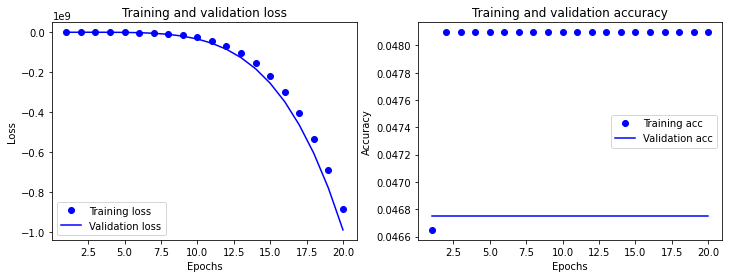

In [66]:
# RNN 그래프

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"입니다
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

|모델|all|10000|5000|2500|
|---|---|---|---|---|
|nb|0.59|0.65|0.67|**0.69**|
|cb|0.76|**0.77**|**0.77**|0.76|
|lr|**0.81**|0.80|0.80|0.78|
|svm|**0.78**|0.77|0.77|0.73|
|d.tree|0.62|0.62|0.61|0.62|
|r.forest|0.65|0.67|**0.70**|**0.70**|
|grbt|**0.77**|0.76|0.76|0.76|
|voting|0.81|0.81|0.81|0.80|

루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

|평가문항|상세기준|
|:---|:---|
|1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가?|3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.|
|2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가?|Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.|
|3. 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?|동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.|

## 회고

빈도수에 따른 단어 사용을 분류하여 8가지의 알고리즘 모델들을 비교해보았다.<br>
종합적으로 정리해본 결과 로지스틱회귀와 보팅이 제일 높은 정확도를 보였다.<br>
단어 개수는 정확도에 큰 차이를 보이지 않은 것 같으나 나이브 베이즈 정리는 단어 빈도수를 줄일 수록 정확도가 높아졌다.<br>
왜 단어 개수가 적을 수록 정확도가 높아질까?? 궁금증이 생겼다.




>https://needjarvis.tistory.com/620<br>
 https://gomguard.tistory.com/69 예제:(스팸메일 분류)

### 나이브 베이즈


베이즈 정리의 대표적인 예시로, 베이즈 정리는 일반인들이 알고 있던 통계의 지식을 무너트리는 역할을 한다. <br>
위 사이트는 베이즈 정리의 예시를 보여주는데 읽으면 좋을 것같다.(대장암 진단 검사기)<br>
핵심은 우리는 상당히 많은 통계의 함정에 빠지게 되고, 어설프게 판단하는 가설이 무서운것이라고 한다.

![](https://cs50.harvard.edu/ai/2020/notes/6/bayesrule.png)
![](https://cs50.harvard.edu/ai/2020/notes/6/naivebayes.png)

P(positive | "my grandson loved it")

Applying Bayes' ruled 
- P("my", "grandson", "loved", "it" | positive)*P(positive)/P("my", "grandson", "loved", "it"). 


나이브 베이즈의 개념
- 목표 값을 예측하는 모든 기능이 **서로 독립적**이라는 가정하에 Bayes의 정리를 기반으로하는 분류 기술이다.
- 각 클래스의 확률을 계산한 다음 확률이 가장 높은 클래스를 선택하는 방법이다.
- 특히 자연어 처리(NLP) 문제에서 잘 작동한다.
- 데이터가 각 클래스에 속할 특징 확률을 계산하는 조건부 확률 기반의 분류 방법이다.
- 나이브(Naïve) : 나이브라는 의미는 순진하다라는 뜻을 담고 있으며 모든 변수(특징)들이 동등하다는 것을 의미한다.


나이브 베이즈의 장점
- 간단하고 빠르며 효율적인 알고리즘
- 잡음과 누락 데이터를 잘 처리한다.
- 훈련을 할 때 데이터의 크기에 상관없이 잘 동작한다.
- 예측을 위한 추정 확률을 쉽게 얻을 수 있다.

나이브 베이즈의 단점
- 수치 특징이 많은 데이터셋에는 이상적이지 않다.
- 모든 데이터의 특징을 독립적인 사건이라고 분류하기 때문에 다른 분류 모델에 따라 제약이 크다.





나이브 베이즈는 간단한 이론으로 구현한 분류기로 **상호 독립적**인 개념때문에 많은 단어장을 가질 수록 단어간의 연관성을 가지지 못해서 결과값이 좋지 않은 것 같다.